# PyDMD

## Developers Tutorial 1: Extending PyDMD

Contrary to other **PyDMD** tutorials, this notebook illustrates the general structure of the basic classes, aiming to help developers to <u>extend</u> the package functionality in a smooth way.

In this tutorial we will indeed create from scratch a new version of the original DMD; such extension will be totally useless from a scientific perspective, the only purpose is showing the suggested steps to implement new variants inside **PyDMD**.

The necessary bricks for building the new DMD version are:

- [`DMDBase`](https://mathlab.github.io/PyDMD/dmdbase.html), the actual backbone of all the different implemented versions;
- `DMDTimeDict`, the class that manages the time window;
- `DMDOperator`, the class that manages the so-called DMD operator;

We start the new module by importing all these classes and the usual math environment (`matplotlib`+`numpy`).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from pydmd import DMDBase, DMD
from pydmd.utils import compute_tlsq

import matplotlib.colors as colors

We are now able to create a new class inheriting from `DMDBase`: in this way we just need to implement the new `fit()` method. We can also overload one or more attributes/methods, depending on the algorithm which we are going to follow.

In this case, we also overload the constructor (i.e. the `__init__` method) to present a non-trivial case. 

### Our simple algorithm
The new functionality we are going to implement is basically a simple DMD which maps the input snapshots using a custom function, provided by the user before of the construction of the operator.

Since the (quite) high number of parameters in the constructor, we suggest to pass explicitly all of them instead of using `args` and `kwargs`. It's redundant, but also much more readable! We can call the `DMDBase` constructor thanks to `super` keyword (more info on `super` [here](https://docs.python.org/3.9/library/functions.html?highlight=super#super)).

In [2]:
class MyFancyNameDMD(DMDBase):
    """
    The MyFancyNameDMD class.
    A dummy DMD variant which, useless outside this tutorial. 
    Make sure to write an exhaustive docstring if you want to
    distribute your code, or use it again in some years.
    """
    def __init__(self, func, **kwargs):
        super().__init__(**kwargs)
        self.__func = func

We just specify that the last line of constructor saves the passed function in the object, giving us the possibility to recall it later.

We are now ready to implement the `fit` method. Define the custom mapping as $f: \mathbb R^n \to \mathbb R^n$ acting on the snapshots $\{\mathbf x_i \in \mathbb R^n\}_{i=1}^m$. Then we just need to pre-process the snapshots in `fit()` and build the DMD operator.

In [3]:
    def fit(self, X):
        """
        Compute the DMD to the input data.
        
        :param X: the input snapshots.
        :type X: numpy.ndarray or iterable
        """
        
        # adjust the shape of the snapshots
        self._snapshots, self._snapshots_shape = self._col_major_2darray(X)

        # apply the mapping
        self._snapshots = np.apply_along_axis(self.__func, 0, self._snapshots)

        # build the matrices X and Y
        n_samples = self._snapshots.shape[1]
        X = self._snapshots[:, :-1]
        Y = self._snapshots[:, 1:]
        X, Y = compute_tlsq(X, Y, self.tlsq_rank)

        # compute the DMD operator
        self._svd_modes, _, _ = self.operator.compute_operator(X,Y)
        
        # Default timesteps
        self._set_initial_time_dictionary(
            {"t0": 0, "tend": n_samples - 1, "dt": 1}
        )

        # compute DMD amplitudes
        self._b = self._compute_amplitudes()

        return self  

By recalling the already implemented methods, we just need few lines of code to complete the new version. Of course, in case of doubts, the [documentation](https://mathlab.github.io/PyDMD/index.html) is the best starting point to better understand classes and methods.

We merge the two cells above in the next one in order to have the entire class implemented.

In [4]:
class MyFancyNameDMD(DMDBase):
    """
    The MyFancyNameDMD class.
    A dummy DMD variant which, useless outside this tutorial. 
    Make sure to write an exhaustive docstring if you want to
    distribute your code, or use it again in some years.
    """
    def __init__(self, func, **kwargs):
        super().__init__(**kwargs)
        self.__func = func
        
    def fit(self, X):
        """
        Compute the DMD to the input data.
        
        :param X: the input snapshots.
        :type X: numpy.ndarray or iterable
        """
        
        # adjust the shape of the snapshots
        self._snapshots, self._snapshots_shape = self._col_major_2darray(X)

        # apply the mapping
        self._snapshots = np.apply_along_axis(self.__func, 0, self._snapshots)

        # build the matrices X and Y
        n_samples = self._snapshots.shape[1]
        X = self._snapshots[:, :-1]
        Y = self._snapshots[:, 1:]
        X, Y = compute_tlsq(X, Y, self.tlsq_rank)

        # compute the DMD operator
        self._svd_modes, _, _ = self.operator.compute_operator(X,Y)
        
        # Default timesteps
        self._set_initial_time_dictionary(
            {"t0": 0, "tend": n_samples - 1, "dt": 1}
        )

        # compute DMD amplitudes
        self._b = self._compute_amplitudes()

        return self  

And, we're done!

Our new class is implemented, inheriting all the methods to the base class. We have nothing to do but try it on a simple example. First of all, we instantiate a new object, passing as function a simple normalizer.

In [5]:
def myfunc(snapshot):
    return snapshot + np.mean(snapshot) * np.random.rand(len(snapshot))

my_dmd = MyFancyNameDMD(func=myfunc)

We recycle the dataset from [tutorial 1](https://mathlab.github.io/PyDMD/tutorial1dmd.html):

In [6]:
def f1(x,t): 
    return 1./np.cosh(x+3)*np.exp(2.3j*t)

def f2(x,t):
    return 2./np.cosh(x)*np.tanh(x)*np.exp(2.8j*t)

x = np.linspace(-5, 5, 65)
t = np.linspace(0, 4*np.pi, 129)

xgrid, tgrid = np.meshgrid(x, t)

X1 = f1(xgrid, tgrid)
X2 = f2(xgrid, tgrid)
X = X1 + X2

The `fit` method we have implemented is now called to perform our algorithm to the input data.

In [7]:
my_dmd.fit(X.T)

/Users/francescoandreuzzi/.local/share/virtualenvs/parametric-dmd-FqHiOHMJ/lib/python3.8/site-packages/pydmd/dmdbase.py:715: UserWarning: Input data matrix X has condition number 2.4567137869170324e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


To check that everything works as expected we compare the results obtained with the new version with respect to the original standard approach. We import the `DMD` class and fit over the same data.

In [8]:
dmd = DMD()
dmd.fit(X.T)

We have performed both the algorithms, we can now look at the reconstructed system using the `reconstructed_data` attribute. We note here that, as the other methods and attributes, `reconstructed_data` is inherited from `DMDBase`, giving us the possibility to call it without having implemented explicitly.

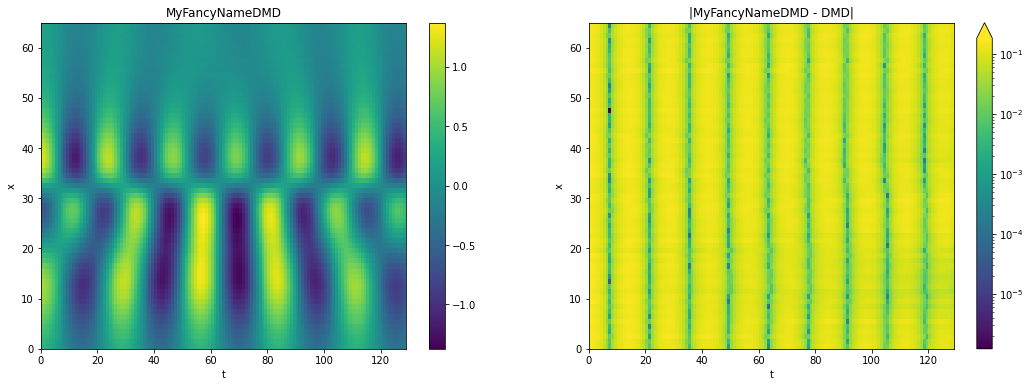

In [9]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.pcolormesh(my_dmd.reconstructed_data.real)
plt.title('MyFancyNameDMD')
plt.xlabel('t')
plt.ylabel('x')
plt.colorbar()

plt.subplot(1,2,2)
Z = np.abs(my_dmd.reconstructed_data.real - dmd.reconstructed_data.real)
pcm = plt.pcolormesh(Z, 
               norm=colors.LogNorm(vmin=max(1.e-16, Z.min()), vmax=max(1.e-15, Z.max())),)
plt.title('|MyFancyNameDMD - DMD|')
plt.xlabel('t')
plt.ylabel('x')
plt.colorbar(pcm, extend='max')

plt.show()

Reconstruction looks fine! We are able to note that, since the normalization of the snapshots, the two approaches returns similar results, just a bit rescaled, that is what we expected by preprocessing in this way the input data.

But what about if we want to rescale back the reconstruction (or the modes) in the new version?
Simple, we have just to overload the `reconstructed_data` or `modes` attributes. 

This is the basic guide to implement a new version of DMD. For more complex changes to the algorithm, we recommend to carefully read the documentation of the package, and maybe reporting in the [Github issues page](https://github.com/mathLab/PyDMD/issues) the extension you are going to implement.